# A Simple Model
This notebook demonstrates various implementations of a simple model to be used in [Rhodium](https://github.com/Project-Platypus/Rhodium/), a Robust Decision Making (RDM) framework. Different implementations of the same model are described in an attempt to cover a number of observed use cases. These include models written in Python as well as external models implemented in languages such as R, C, C++, and Fortran.

In all cases, the initial parameters will be read from an Excel file; however, the same principle applies to a number of other file formats such as CSV, JSON, etc.

## Setting Things Up

Python makes it easy to import external libraries, called "packages", using the `import` command. Any packages that aren't included with Python can be installed using the `pip` package manager. Just type `pip install <package_name>` in the command line to install. Let's begin by importing some Python packages we'll be using.

In [1]:
from rhodium import *
from openpyxl import load_workbook
from itertools import islice
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

---
### Reading an Excel File
Before we can use a model we need to define it along with its parameters. The model can be implemented internally, as a Python function with Python variables as parameters; models can also be imported from external source codes and libraries. Regardless of how the model is defined, the parameters can be read from data files in a number of different formats including Excel, CSV, JSON, etc. <u>In this notebook, we'll be focusing on reading the parameters from Excel files with different model implementations.</u>

*Models can also be run directly, and interactively, by formulas in Excel workbooks. This is covered in the [interactive version](SimpleModelDemo-interactive.ipynb) of this notebook and requires 1) a local installation of Anaconda Python 2.7 (which includes IPython), and 2) a copy of Microsoft Excel.*

An example of the input and output worksheets are displayed below. In addition to the parameter values and labels, the inputs have a range of specificed values described by the `Low` and `High` column headers. These can be used to define uncertainty ranges or policy levers in Rhodium. The input and output values have been highlighted.

Throughout this notebook, we'll use a simple model that receives a set of ten input parameters (labeled `Var1`, `Var2`, ..., `Var10`) and multiplies and adds somewhat arbitrary values to generate the five output values (labeled `Output1`, `Outputs2`,...`Output5`).

| ![Inputs](images/input_sheet.png "Inputs") | ![Outputs](images/output_sheet.png "Outputs") |                        
|:------------------------------------------:|:---------------------------------------------:|
| INPUTS                                     | OUTPUTS                                       |

Now, let's read our data from the Excel workbook.

In [2]:
# Connect to existing Excel workbook
wb = load_workbook('SimpleModel.xlsx')

output_sheet = wb['OUTPUTS']    # for output labels
input_sheet = wb['INPUTS']      # for input labels, lever and uncertainty ranges

# Define helper function to set up Pandas DataFrame
def get_dataframe_with_headers(ws):
    data = ws.values
    cols = next(data)[1:]
    data = list(data)
    idx = [r[0] for r in data]
    data = (islice(r, 1, None) for r in data)
    df = DataFrame(data, index=idx, columns=cols)
    return df
    
df_input = get_dataframe_with_headers(input_sheet)
df_output = get_dataframe_with_headers(output_sheet)

//anaconda/lib/python2.7/site-packages/openpyxl/reader/worksheet.py:310: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


I've defined a helper function called `get_dataframe_with_headers`, which facilitates reading the spreadsheets with the row and column headers. The data gets returned as a [Pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe), a powerful and flexible data structure for data manipulation and analysis. It can easily be converted and/or written to common formats such as Excel/CSV or JSON.

Let's print out the input data to make sure it was read correctly.

In [3]:
df_input 

,Value,Low,High
Var1,5,1,10
Var2,2,1,10
Var3,5,1,10
Var4,2,1,10
Var5,5,1,10
Var6,2,1,10
Var7,5,1,10
Var8,2,1,10
Var9,5,1,10
Var10,2,1,10


Now let's look into the models themselves.

---
## Case #1: External Models
In many cases the models will be defined in another language such as C, C++, R, or Fortran. 

For models written in R, Rhodium can translate the code directly into Python by using its "R Bridge" module. This requires a package called `pyper`. If you haven't installed this already typing `pip install pyper` on the command line should take care of it for you.

For models in compiled languages such as C/C++ and Fortran, Rhodium's so-called "Native Function" support enables us to tap into the shared libraries generated during compilation. These libraries enable Rhodium to run specific functions in languages as if it were in natively in that environment - hence the term.

In UNIX/Linux operating systems, these are files with `*.so` extensions. In Windows systems they're called dynamic link libraries and carry a `*.dll` extension. 

### R Models
*<u>Note: If you're running this notebook on your local machine, this section assumes you have already installed R.</u>*

To best serve this somewhat contrived example, we'll have to reverse engineer the model defined in the Excel workbook. We'll create a separate R script with a function that takes the expected inputs, performs the calculations, and returns the outputs. Functionally, it will be identical to our the model defined internally in the Excel workbook. This R script has been implemented in the file [simple_model.r](./simple_model.r), which we'll use throughout the remainder of this section. 

First, let's import this R Bridge from Rhodium.

In [4]:
from rhodium.rbridge import RModel

We need to tell Rhodium to look in the R file and use the `simple_model` function as our model.

In [5]:
# define model
model_r = RModel('simple_model.r', 'simple_model')

`model_r` is now our R model in Rhodium. Now we'll need to tell Rhodium about what parameters our model expects and how they should be treated. For instance, are they ordinary input parameters, uncertainties, levers, outputs?

In [6]:
# define general parameters
model_r.parameters = [
    Parameter( df_input.index[0] ),
    Parameter( df_input.index[1] ),
    Parameter( df_input.index[2] ),
    Parameter( df_input.index[3] ),
    Parameter( df_input.index[4] ),
    Parameter( df_input.index[5] ),
    Parameter( df_input.index[6] ),
    Parameter( df_input.index[7] ),
    Parameter( df_input.index[8] ),
    Parameter( df_input.index[9] )
] 

# set these parameters as uncertainties
model_r.uncertainties = [
    UniformUncertainty( df_input.index[0], df_input['Low'][0], df_input['High'][0] ),    
    UniformUncertainty( df_input.index[1], df_input['Low'][1], df_input['High'][1] ),   
    UniformUncertainty( df_input.index[2], df_input['Low'][2], df_input['High'][2] ),  
    UniformUncertainty( df_input.index[3], df_input['Low'][3], df_input['High'][3] ), 
    UniformUncertainty( df_input.index[4], df_input['Low'][4], df_input['High'][4] ),
    UniformUncertainty( df_input.index[5], df_input['Low'][5], df_input['High'][5] ),
    UniformUncertainty( df_input.index[6], df_input['Low'][6], df_input['High'][6] ),
    UniformUncertainty( df_input.index[7], df_input['Low'][7], df_input['High'][7] ),
    UniformUncertainty( df_input.index[8], df_input['Low'][8], df_input['High'][8] ),
    UniformUncertainty( df_input.index[9], df_input['Low'][9], df_input['High'][9] )
]

# define outputs
model_r.responses = [
    Response( df_output.index[0] ),
    Response( df_output.index[1] ),
    Response( df_output.index[2] ),
    Response( df_output.index[3] ),
    Response( df_output.index[4] )
]

### Evaluating the Model with Uncertainties
We've defined the input variables as uncertainties over a uniform distribution. We can sample over these uncertainties to generate multiple states of the world (SOWs). The following code generates 100 altenate parametrizations of our input variables by sampling the uncertainty parameter space using the Latin Hypercube sample (LHS) method.

In [7]:
SOWs = sample_lhs(model_r, 100)

This will generate the sampled inputs that will be passed to the model and evaluated. The code below saves the generated case data in a tabular form (once again, as a Pandas DataFrame) that can be easily exported to the same Excel file. We'll see how to do this shortly, but before, let's evaluate the model over the 100 SOWs we generated and display the results.

In [8]:
results = evaluate(model_r, SOWs)
df_results = results.as_dataframe().sort_index(axis=1)
df_results

,Output1,Output2,Output3,Output4,Output5,Var1,Var10,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9
0,6.363472,7.464922,8.640019,0.893504,6.491420,6.371236,9.053751,3.580428,4.262245,2.401367,4.584902,8.168597,8.463635,8.740857,2.443892
1,6.474395,5.326830,1.066226,1.363392,0.945806,7.914210,1.319140,1.310689,7.886939,2.877198,2.636795,1.332779,6.304501,1.031981,3.729117
2,10.707698,12.457138,1.534244,2.322965,1.063759,7.738515,1.483652,8.101557,5.611227,3.645523,8.478557,8.952753,7.366118,1.500109,6.353718
3,9.885375,13.311481,3.511280,3.042038,2.858517,8.046199,3.986848,6.371507,6.658922,3.966494,9.097242,8.560456,2.779049,3.558123,8.320511
4,2.733387,12.006667,3.364184,0.560221,5.103560,1.958796,7.118067,1.779804,2.052918,8.311579,3.802529,6.982645,9.949014,3.344391,1.532302
5,7.939765,14.616378,6.832045,3.210469,0.999411,1.404705,1.393905,7.275994,5.562751,8.472460,6.327802,7.135752,8.859810,6.892546,8.781199
6,3.605108,16.222140,7.529852,1.224006,3.304662,1.275048,4.609097,1.224001,6.291821,9.647381,7.266793,3.340363,9.632897,7.597702,3.347873
7,5.499701,13.397683,8.091920,3.150450,2.553857,4.304980,3.561931,4.065454,2.773018,7.924580,5.518249,7.813062,9.189984,8.175148,8.617038
8,4.085159,9.451572,2.788939,0.786997,1.581866,3.633464,2.206269,2.031082,3.725665,4.818324,4.287557,8.752796,3.326117,2.816215,2.152575
9,7.951661,9.983851,9.721791,1.175117,0.865249,6.735521,1.206785,4.610023,6.190285,1.768318,7.748476,8.507703,5.967964,9.866811,3.214151


We can save the results to an Excel file (including the same file used to read the model data). We'll save it to a new file called `SimpleModel_wResults.xlsx`, in a separate sheet called `UNCERTAINTY RESULTS`. 

*<u>Caution: Running the following block of code multiple times will generate just as any duplicate sheets!<u>*

In [9]:
from openpyxl.utils.dataframe import dataframe_to_rows

database_sheet = wb.create_sheet(title="UNCERTAINTY RESULTS")

for r in dataframe_to_rows(df_results, index=True, header=True):
    database_sheet.append(r)

wb.save('SimpleModel_wResults.xlsx')

### Multi-Objective Optimization
Instead of defining our input variables as being bound by uncertainty (as we did previously), we can redefine them as policy levers that can be adjusted to optimize the outputs in a multi-objective optimization algorithm. The following code does just that.

In [10]:
# re-define inputs as levers
model_r.levers = [
    IntegerLever( df_input.index[0], df_input['Low'][0], df_input['High'][0] ),    
    IntegerLever( df_input.index[1], df_input['Low'][1], df_input['High'][1] ),   
    IntegerLever( df_input.index[2], df_input['Low'][2], df_input['High'][2] ),  
    IntegerLever( df_input.index[3], df_input['Low'][3], df_input['High'][3] ), 
    IntegerLever( df_input.index[4], df_input['Low'][4], df_input['High'][4] ),
    IntegerLever( df_input.index[5], df_input['Low'][5], df_input['High'][5] ),
    IntegerLever( df_input.index[6], df_input['Low'][6], df_input['High'][6] ),
    IntegerLever( df_input.index[7], df_input['Low'][7], df_input['High'][7] ),
    IntegerLever( df_input.index[8], df_input['Low'][8], df_input['High'][8] ),
    IntegerLever( df_input.index[9], df_input['Low'][9], df_input['High'][9] )
]

# re-define outputs with optimizations
model_r.responses = [
    Response( df_output.index[0], Response.MAXIMIZE ),
    Response( df_output.index[1], Response.MINIMIZE ),
    Response( df_output.index[2], Response.MAXIMIZE ),
    Response( df_output.index[3], Response.MINIMIZE ),
    Response( df_output.index[4], Response.INFO ) # disregard during optimization
]

In the code above, we're defining the inputs as integer-valued levers. Rhodium gives us various options to choose from including real and categorical values.

Notice that outputs ("responses" in Rhodium speak) now include an extra bit of code, e.g. `Response.MAXIMIZE`. These tell Rhodium how to use the outputs during the optimization. Using `Response.MAXIMIZE` tells Rhodium to maximize that output value. Similarly, `Response.MINIMIZE` minimizes that output. In addition, using `Response.INFO` or `Response.IGNORE` tells Rhodium to disregard that output during optimization. This may be useful, for instance, if we only want to use that output for visualization. 

*<u>Note: The order in which the optimized responses are defined matters.</u>*

We can now generate alternative designs by varying the input values within their specified limits. We can find Pareto-approximate solutions using the NSGA-II multi-objective oprimization algorithm.

This is among the most time-consuming parts of the analysis so let's make a note of how long it takes to run.

In [11]:
start_time = time.time()                     # for timing
output_r = optimize(model_r, 'NSGAII', 500)
runtime_r = time.time() - start_time         # for timing
print 'Runtime {:0.1f}s'.format(runtime_r)   # for timing

Runtime 7.1s


Now let's convert our results as a Pandas DataFrame and display the generated cases in tabular form.

In [12]:
df_results = output_r.as_dataframe().sort_index(axis=1)
df_results

,Output1,Output2,Output3,Output4,Output5,Var1,Var10,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9
0,12.721557,8.201756,9.809106,0.365607,5.018907,8,7,10,7,1,7,5,1,10,1
1,11.287510,2.187222,5.915039,1.828036,0.716987,8,1,10,3,1,1,3,4,6,5
2,12.270354,15.536807,9.869997,1.096821,4.301921,9,6,8,9,9,7,5,8,10,3
3,14.469529,7.024618,2.047070,2.924857,0.716987,10,1,10,10,5,2,5,10,2,8
4,14.469529,9.726844,4.961095,0.365607,2.150960,10,3,10,10,7,3,4,7,5,1
5,9.110628,2.388160,9.861299,3.656071,1.433974,6,2,8,3,1,1,5,7,10,10
6,8.208222,5.343376,9.878696,1.096821,5.735894,8,8,4,7,2,3,6,9,10,3
7,11.124420,6.211839,9.887395,2.924857,5.018907,9,7,6,10,2,4,5,10,10,8
8,13.358795,9.267524,3.937560,0.731214,0.716987,10,1,9,9,3,6,7,2,4,2
9,12.721557,14.571508,9.869997,2.193643,0.716987,8,1,10,7,7,8,4,8,10,6


## Visualization
Here are a few ways to visualize the optimization results.

In [13]:
# set display preferences
sns.set()
sns.set_style('darkgrid')

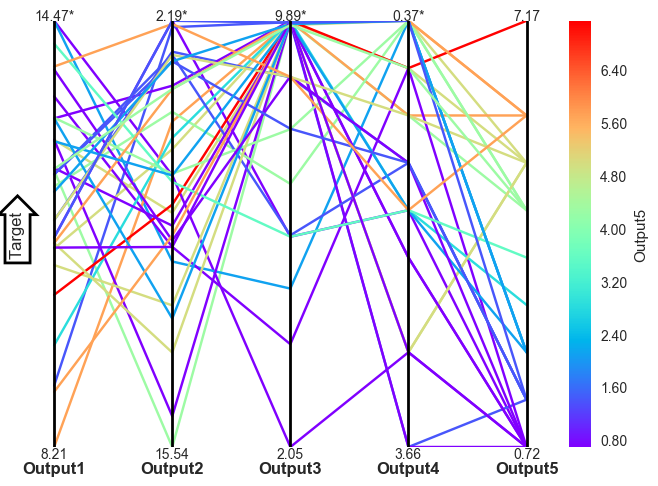

In [14]:
parallel_coordinates(model_r, output_r, colormap='rainbow', target='top')
plt.show()

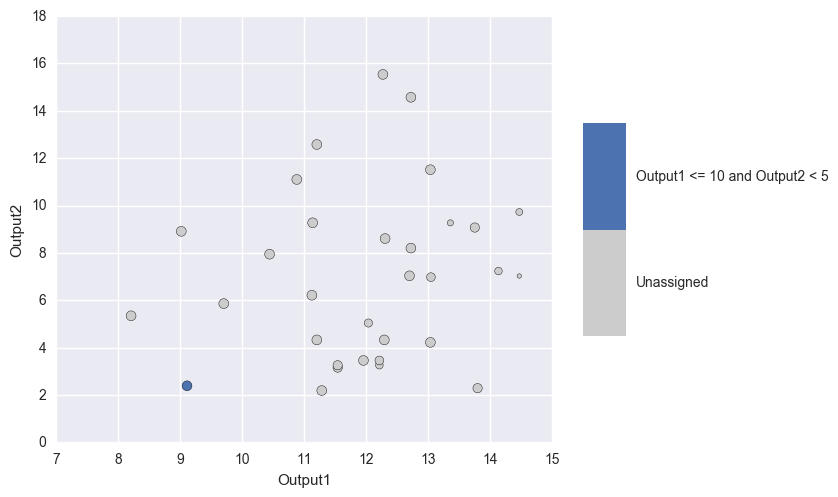

In [15]:
scatter2d(model_r, output_r, brush="Output1 <= 10 and Output2 < 5")
plt.show()

Create Artists


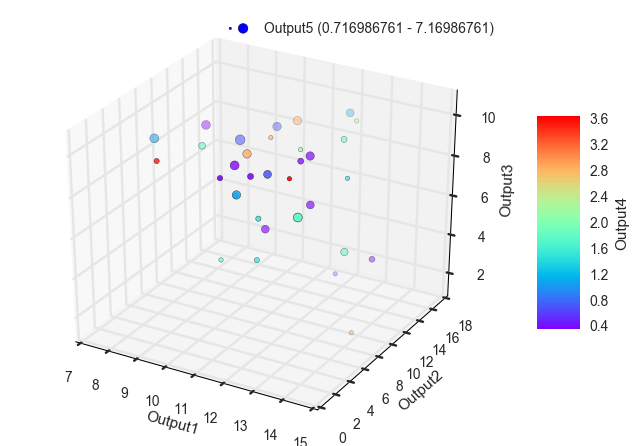

In [16]:
scatter3d(model_r, output_r, s="Output5", show_legend=True)
plt.show()

---
## Case #2: Using a Python Model

Some models may be already implemented in Python. As far as Rhodium's performance is concerned, this is an ideal case because there is less computational overhead in accessing the data and driving third-party software.

### Constructing the Model
As in the R script we just saw, let's re-implement the model, this time in Python.

In [17]:
def simple_model_py(Var1, Var2, Var3, Var4, Var5, Var6, Var7, Var8, Var9, Var10):
    
    # handle some internal calculations
    Expression1 = Var1 * 0.336218764
    Expression2 = Var2 * 0.75222251
    Expression3 = Var3 * 0.358511648
    Expression4 = Var4 * 0.916881328
    Expression5 = Var5 * 0.968932684
    Expression6 = Var6 * 0.100469201
    Expression7 = Var7 * 0.008698836
    Expression8 = Var8 * 0.980040676
    Expression9 = Var9 * 0.36560712
    Expression10 = Var10 * 0.716986761    
    
    # evaluate outputs
    Output1 = Expression1 + Expression2 + Expression3 
    Output2 = Expression4 + Expression5 + Expression6
    Output3 = Expression7 + Expression8
    Output4 = Expression9 
    Output5 = Expression10
    
    return [ Output1, Output2, Output3, Output4, Output5 ]

### Setting up Rhodium
We'll set up the model in Rhodium and treat the inputs as policy levers with the purpose of running a multi-objective optimization. This is no different than before.

In [18]:
model_py = Model(simple_model_py)

model_py.parameters = [
    Parameter( df_input.index[0] ),
    Parameter( df_input.index[1] ),
    Parameter( df_input.index[2] ),
    Parameter( df_input.index[3] ),
    Parameter( df_input.index[4] ),
    Parameter( df_input.index[5] ),
    Parameter( df_input.index[6] ),
    Parameter( df_input.index[7] ),
    Parameter( df_input.index[8] ),
    Parameter( df_input.index[9] )
] 

model_py.levers = [
    IntegerLever( df_input.index[0], df_input['Low'][0], df_input['High'][0] ),    
    IntegerLever( df_input.index[1], df_input['Low'][1], df_input['High'][1] ),   
    IntegerLever( df_input.index[2], df_input['Low'][2], df_input['High'][2] ),  
    IntegerLever( df_input.index[3], df_input['Low'][3], df_input['High'][3] ), 
    IntegerLever( df_input.index[4], df_input['Low'][4], df_input['High'][4] ),
    IntegerLever( df_input.index[5], df_input['Low'][5], df_input['High'][5] ),
    IntegerLever( df_input.index[6], df_input['Low'][6], df_input['High'][6] ),
    IntegerLever( df_input.index[7], df_input['Low'][7], df_input['High'][7] ),
    IntegerLever( df_input.index[8], df_input['Low'][8], df_input['High'][8] ),
    IntegerLever( df_input.index[9], df_input['Low'][9], df_input['High'][9] )
]

model_py.responses = [
    Response( df_output.index[0], Response.MAXIMIZE ),
    Response( df_output.index[1], Response.MINIMIZE ),
    Response( df_output.index[2], Response.MAXIMIZE ),
    Response( df_output.index[3], Response.MINIMIZE ),
    Response( df_output.index[4], Response.MAXIMIZE )
]

Let's perform a quick sanity check. Having defined the same model in different ways, they should both behave the same way. We'll create a set of input parameters and evaluate them with each model. They should produce identical results.

In [19]:
import collections

# define test inputs as ordered dictionary
test_inputs = collections.OrderedDict([
    ('Var1', 5),
    ('Var2', 2),
    ('Var3', 5),
    ('Var4', 2),
    ('Var5', 5),
    ('Var6', 2),
    ('Var7', 5),
    ('Var8', 2),
    ('Var9', 5),
    ('Var10', 2),          
])

# evaluate using different models
outputs_r  = evaluate(model_r, test_inputs)
outputs_py = evaluate(model_py, test_inputs)

print 'Difference in output values: '
print 'Output1: ' + '{:0.8f}'.format( outputs_py['Output1'] - outputs_r['Output1'] )
print 'Output2: ' + '{:0.8f}'.format( outputs_py['Output2'] - outputs_r['Output2'] )
print 'Output3: ' + '{:0.8f}'.format( outputs_py['Output3'] - outputs_r['Output3'] )
print 'Output4: ' + '{:0.8f}'.format( outputs_py['Output4'] - outputs_r['Output4'] )
print 'Output5: ' + '{:0.8f}'.format( outputs_py['Output5'] - outputs_r['Output5'] )

Difference in output values: 
Output1: -0.00000000
Output2: 0.00000000
Output3: 0.00000000
Output4: 0.00000000
Output5: 0.00000000


### Multi-Objective Optimization
Once again, we'll run the optimization taking note of the runtime.

In [20]:
start_time = time.time()
output_py = optimize(model_py, 'NSGAII', 500)
runtime_py = time.time() - start_time
print 'Runtime {:0.1f}s'.format(runtime_py)

Runtime 0.7s


**Note the significant gain in performance by running the model within the Python environment!**

Again, we display the generated case data.

In [21]:
df = output_py.as_dataframe().sort_index(axis=1)
df

,Output1,Output2,Output3,Output4,Output5,Var1,Var10,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9
0,9.655175,8.709494,8.898656,0.365607,4.301921,9,6,5,8,6,3,3,9,9,1
1,11.956428,5.391794,9.887395,1.462428,4.301921,7,6,8,10,3,2,7,10,10,4
2,13.044869,5.806329,7.849024,0.365607,0.716987,8,1,9,10,4,2,2,1,8,1
3,9.478526,2.187222,5.941136,1.096821,5.018907,4,7,7,8,1,1,3,7,6,3
4,13.438580,4.024618,2.974917,0.365607,6.452881,8,9,10,9,1,3,2,4,3,1
5,10.788202,2.955216,6.947273,3.290464,5.018907,8,7,6,10,1,2,1,10,7,9
6,5.464499,2.589098,8.872559,1.462428,3.584934,4,5,5,1,1,1,7,6,9,4
7,12.721557,12.879365,1.058330,2.193643,7.169868,8,10,10,7,10,3,8,9,1,6
8,10.150963,2.903165,6.903779,0.365607,7.169868,6,10,7,8,2,1,1,5,7,1
9,9.469139,17.727662,9.835202,0.731214,5.018907,6,7,8,4,8,10,7,4,10,2


---
## Comparing the Model Implementations
So how did the different models compare when it comes to optimization? Let's see...

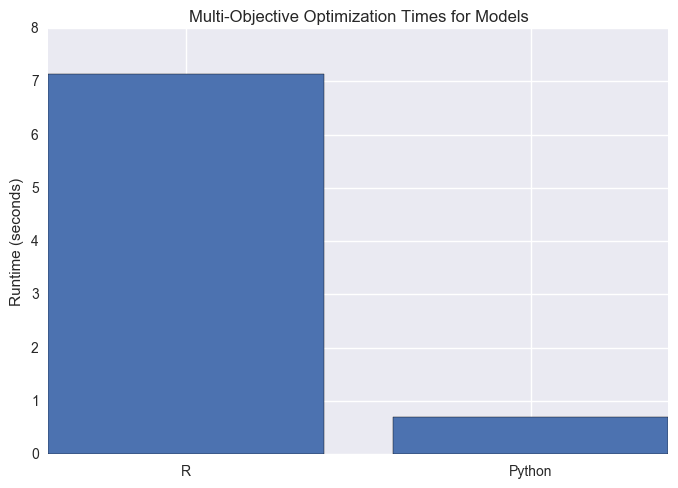

In [22]:
objects = ('R', 'Python')
y_pos = np.arange(len(objects))
performance = [runtime_r, runtime_py]
 
plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Runtime (seconds)')
plt.title('Multi-Objective Optimization Times for Models')
 
plt.show()

Not surprisingly, the optimization for the internal Python model ran significantly faster than the R model.